<a href="https://colab.research.google.com/github/Dynami/quantcon2018/blob/master/Quantcon_RL_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir appo_lib
%cd appo_lib

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz;

%cd ta-lib
!./configure --prefix=/usr
!make;
!make install;
!pip install Ta-Lib
import talib

In [2]:
%cd ../../
!pwd
!ls -l

/content
/content
total 8
drwxr-xr-x 3 root root 4096 Apr 10 17:50 appo_lib
drwxr-xr-x 1 root root 4096 Apr  3 16:24 sample_data


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import talib
import traceback

%matplotlib inline

In [0]:
import requests
url = "https://github.com/Dynami/quantcon2018/blob/master/data.txt?raw=true"
r = requests.get(url)

f = open('data.txt', 'w')
f.write(r.content.decode("utf-8") )
f.close()

### Parse a data file into Pandas

In [5]:
dateparse = lambda x,y: pd.datetime.strptime(x+' '+y, '%m/%d/%Y %H:%M')
df_full = pd.read_csv('data.txt',parse_dates=[[0,1]],index_col=0,skiprows=0,date_parser=dateparse)
df_full.index.rename('Time',inplace=True)
df_full.columns = ['open','high','low','close','volume']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


### Plot the data

### Filtering data by time between 9 and 18

In [0]:
df_full_lite = df_full.loc[df_full.index.hour >= 9]
df_full_lite = df_full_lite.loc[df_full_lite.index.hour <= 17]
time = df_full_lite.index.hour*100 + df_full_lite.index.minute

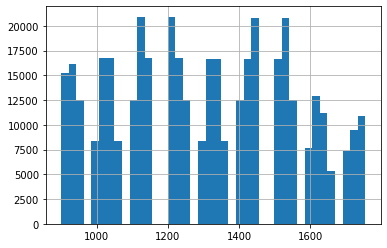

In [7]:
plt.hist(time, bins=40)
plt.grid()

In [0]:
df_full.iloc[-70:][['open', 'high', 'low', 'close']].plot()
plt.show()

### Create a synthetic test series

Here we create a sine wave and a trend line. 
The parameter mult determines the amount of noise in our system

In [0]:
def create_synth_series(x,y,mult=1):    
    op = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    cl = pd.Series(y+mult*np.random.randn(len(df)),index=df.index)
    hi = pd.Series(y+1+mult*np.abs(np.random.randn(len(df))),index=df.index)
    lo = pd.Series(y-1-mult*np.abs(np.random.randn(len(df))),index=df.index)
    dfs = pd.DataFrame([op,hi,lo,cl]).T
    dfs.index.rename('Time',inplace=True)
    dfs.columns = ['open','high','low','close']
    return dfs

In [0]:
np.min(df_full.index.hour), np.max(df_full.index.hour)

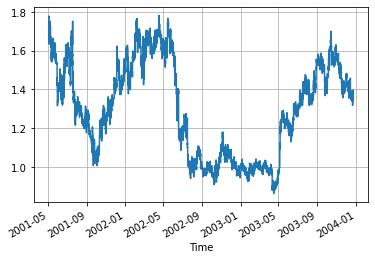

In [14]:
df_full_lite.iloc[70000:130000]['close'].plot()
plt.grid()

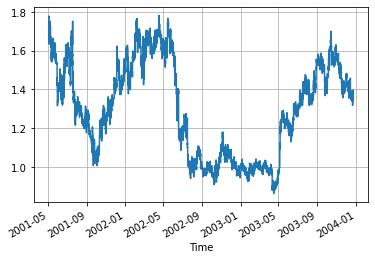

In [16]:
#df = df_full.iloc[70000:150000]
df = df_full_lite.iloc[70000:130000]
df['close'].plot()
plt.grid()
plt.show()

In [0]:
ldf = len(df)
mid= int(ldf/2)
x = np.arange(len(df))
y = np.zeros(ldf)
y[mid:] = 0.01*x[:mid]+100
y[:mid] = 10*np.sin(0.01*x[:mid])+100#+y[mid-1]
dft = create_synth_series(x,y,mult=0.00)

### This is the Reinforcement Learning part of the system

In [0]:
def cycle(a, len=7):
  return np.cos(2 * np.pi * a / len)

def scale(x:np.array, min=None, max=None):
  _min = min if min is not None else np.min(x)
  _max = max if max is not None else np.max(x)
  #print(_min, _max)
  return 2*(x-_min)/(_max-_min) - 1

def smoothF(period):
    return 2./(period+1)

def highPassFilter(data, period = 48):
    a = (0.707*2*math.pi)/period
    alpha1 = 1.+(math.sin(a)-1.)/math.cos(a)
    b = 1.-alpha1/2.
    c = 1.-alpha1
    
    hp = np.zeros((data.shape[0],));
    for i in range(3, data.shape[0]):
        subset = data[i-3:i]
        hp[i] = b*b*(subset[-1] - 2*subset[-2] + subset[-3]) + 2 * c * hp[i-1] - c * c * hp[i-2]
    hp = pd.Series(name='hp', index=data.index, data=hp)
    return hp

def lowPassFilter(data, period):
    #lp = np.zeros((data.shape[0],))
    lp = np.copy(data)
    a = smoothF(period)
    a2 = a**2
    for i in range(4, data.shape[0]):
        subset = data[i-4:i]
        lp[i] = (a - 0.25 * a2)*subset[-1] \
                + 0.5*a2*subset[-2] \
                - (a-0.75*a2)*subset[-3] \
                + 2*(1-a)*lp[i-1] \
                - ((1.-a)**2)*lp[i-2]
        
    #lp = pd.Series(name='lp', index=data.index, data=lp)
    return lp

def mmi(data):
    '''
    Market Meanness Index
    '''
    data = np.reshape(data, (-1))
    m = np.median(data)
    #print(data[-10:], m)
    length = len(data)
    nh, nl = 0, 0
    for i in range(1, length):
        if(data[i-1] > m and data[i-1] > data[i]):
            nl = nl+1
        elif(data[i-1] < m and data[i-1] < data[i]):
            nh = nh+1
    
    return 100.0 * (nl+nh)/(length-1)

def market_meanness_index(data, period):
    mmis = np.ones((period,))
    mmis *= 50
    mmis = mmis.tolist()
    for i in range(period, len(data)):
        subset = data[i-period:i]
        _mmi = mmi(subset)
        mmis.append(_mmi)
    return np.array(mmis)

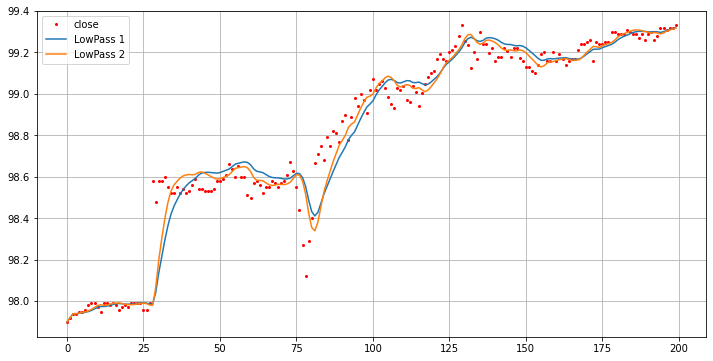

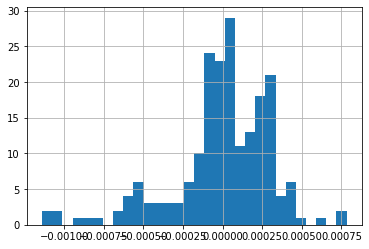

In [18]:
cl = df_full.iloc[-200:].close.values
lp1 = lowPassFilter(cl, 20)
lp2 = lowPassFilter(cl, 13)

plt.figure(figsize=(12, 6))
plt.plot(cl, label='close', ls=' ',  marker='o', markersize=2, color='r')
plt.plot(lp1, label='LowPass 1')
plt.plot(lp2, label='LowPass 2')
plt.legend()
plt.grid()
plt.show()

plt.hist((lp1 - lp2)/lp2, bins=30)
plt.grid()
plt.show()

In [0]:
a = np.arange(100)%31
a = cycle(a, 31)
plt.plot(a)
plt.grid()

In [0]:
class ExperienceReplay(object):
    '''This class gathers and delivers the experience'''
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            #pred = model.predict(state_t)
            #print('ExperienceReplay::get_batch() 1', pred)
            targets[i] = model.predict(state_t)[0]
            #pred = model.predict(state_tp1)
            #print('ExperienceReplay::get_batch() 2', pred)
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                #print('reward_t + gamma * max_a1 Q(s1, a1)', reward_t + self.discount * Q_sa)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

### Defining the "Trading Game"

Here we define our state, reward and policy.

In [0]:
class Game(object):
    '''This is the game. It starts, then takes an action (buy or sell) at some point and finally the reverse
    action, at which point it is game over. This is where the reward is given. The state consists of a vector
    with different bar sizes for OLHC. They are just concatenated. 
    lkbk: determines how many bars to use - larger lkbk - bigger state
    '''
    def __init__(self, df, lkbk=20, max_game_len=1000, run_mode='sequential', init_idx=None):
        self.df = df
        self.lkbk = lkbk
        self.max_game_len = max_game_len
        
        self.is_over = False
        self.reward = 0
        self.run_mode =  run_mode
        self.pnl_sum = 0
        if run_mode == 'sequential' and init_idx == None:
            print('------No init_idx set for "sequential": stopping------')
            return
        else:
            self.init_idx = init_idx
        self.reset()
        
    def _update_state(self, action):
        
        '''Here we update our state'''
        self.curr_idx += 1
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_price = self.df['close'][self.curr_idx]
        self.pnl = (-self.entry + self.curr_price)*self.position/self.entry
        self.side = 1 if self.curr_price > self.entry else -1
        self._assemble_state()
        _h = self.curr_time.hour-9 #starts at 9:00 ends at 18:00
        _m = self.curr_time.minute
        #_k = list(map(float,str(self.curr_time.time()).split(':')[:2]))
        #print('Game::_update_state() _k', _k)
        self._time_of_day = cycle(_h*60 + _m, 9*60) 
        self._day_of_week  = cycle(self.curr_time.weekday(), 7)
        self.norm_epoch = (df.index[self.curr_idx]-df.index[0]).total_seconds()/self.t_in_secs
        
        '''This is where we define our policy and update our position'''
        if action == 0:  
            pass
        
        elif action == 2:
            if self.position == -1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx
   
            elif self.position == 0:
                self.position = 1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else: 
                pass
            
        elif action == 1:
            if self.position == 1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx

            elif self.position == 0:
                self.position = -1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else:
                pass
        
    
    def _assemble_state(self):
        '''Here we can add other things such as indicators and times'''
        self._get_last_N_timebars()
        bars = [self.last5m] #, self.last1h, self.last1d
        state = []
        candles = {j:{k:np.array([]) for k in ['open','high','low','close']} for j in range(len(bars))}
        for j,bar in enumerate(bars):
            for col in ['open','high','low','close']:
                candles[j][col] = np.asarray(bar[col])
                state += (list(np.asarray(bar[col]))[-10:])

        state = scale(np.array(state))
        self.state = np.array([])
        #self.state = np.append(self.state, state)
        self.state = np.append(self.state, self.position)
        #self.state = np.append(self.state, np.sign(self.pnl_sum))
        self.state = np.append(self.state, scale(self.pnl_sum, min=-0.02, max=0.02))
        self.state = np.append(self.state, self._time_of_day)
        self.state = np.append(self.state, self._day_of_week)

        #print('Game::_assemble_state() First block', self.state)
        self.lookback = 5
        for c in candles:
            try:
                
                f1 = lowPassFilter(candles[c]['close'], self.lkbk-1)[-self.lookback:]
                f2 = lowPassFilter(candles[c]['close'], self.lkbk-8)[-self.lookback:]
                tmp = scale( (f2-f1)/f1, -0.01, 0.01)
                #print('Game::_assemble_state() LowPass cross', tmp)
                self.state = np.append(self.state, tmp)

                #sma1 = talib.EMA(candles[c]['close'],self.lkbk-1)[-1]
                #sma2 = talib.EMA(candles[c]['close'],self.lkbk-8)[-1]
                #tmp = scale((sma1-sma2)/sma2, -0.2, 0.2)
                #self.state = np.append(self.state, tmp)
                
                #self.state = np.append(self.state,sma1)
                tmp = scale(talib.RSI(candles[c]['close'])[-self.lookback:], 0, 100)
                #print('Game::_assemble_state() RSI', tmp)
                self.state = np.append(self.state,tmp)
                
                tmp = scale(talib.MOM(candles[c]['close'])[-self.lookback:], -3, 3)
                #print('Game::_assemble_state() MON', tmp)
                self.state = np.append(self.state, tmp)
                ##self.state = np.append(self.state,talib.MACD(candles[c]['close'],fastperiod=11, slowperiod=22, signalperiod=9)[0][0])
                #self.state = np.append(self.state,talib.BOP(candles[c]['open'],
                #                               candles[c]['high'],
                #                               candles[c]['low'],
                #                               candles[c]['close'])[-1])
                ##self.state = np.append(self.state,talib.ADXR(candles[c]['high'],
                ##                               candles[c]['low'],
                ##                               candles[c]['close'],
                ##                               self.lkbk-3)[-1]) 
                ##self.state = np.append(self.state,talib.STOCH(candles[c]['high'],
                ##                               candles[c]['low'],
                ##                               candles[c]['close'],5,3,0,3,0)[-1][0])
                tmp = talib.AROONOSC(candles[c]['high'],
                                               candles[c]['low'])[-self.lookback:]
                #print('Game::_assemble_state() AROONOSC', tmp)
                tmp = scale(tmp, 0, 100)
                self.state = np.append(self.state, tmp)
            except: print(traceback.format_exc())
        #print(np.min(self.state), np.max(self.state))
        #print('-->',self.state.shape)
        #self.state = (np.array(self.state)-np.mean(self.state))/np.std(self.state)
        
    def _get_last_N_timebars(self):
        '''The lengths of the time windows are currently hardcoded.'''
        # TODO: find better way to calculate window lengths
        wdw5m = 9
        wdw1h = np.ceil(self.lkbk*15/24.)
        wdw1d = np.ceil(self.lkbk*15)
        
        self.last5m = self.df[self.curr_time-timedelta(wdw5m):self.curr_time].iloc[-self.lkbk:]
        self.last1h = self.bars1h[self.curr_time-timedelta(wdw1h):self.curr_time].iloc[-self.lkbk:]
        self.last1d = self.bars1d[self.curr_time-timedelta(wdw1d):self.curr_time].iloc[-self.lkbk:]
        
        '''Making sure that window lengths are sufficient'''
        try:
            assert(len(self.last5m)==self.lkbk)
            assert(len(self.last1h)==self.lkbk)
            #assert(len(self.last1d)==self.lkbk)
        except:
            print('****Window length too short****')
            print(len(self.last5m),len(self.last1h),len(self.last1d))
            if self.run_mode == 'sequential':
                self.init_idx = self.curr_idx
                self.reset()
            else:
                self.reset()

    def _original_get_reward(self):
        if self.position == 1 and self.is_over:
            pnl = (self.curr_price - self.entry)/self.entry
            self.reward = np.sign(pnl)#-(self.curr_idx - self.start_idx)/1000.
        elif self.position == -1 and self.is_over:
            pnl = (-self.curr_price + self.entry)/self.entry
            self.reward = np.sign(pnl)#-(self.curr_idx - self.start_idx)/1000.
        return self.reward

    def _get_reward(self):
        pnl = self.position * (self.curr_price - self.entry)/self.entry
        pnl = pnl *100
        dist = self.curr_idx - self.start_idx
        #factor = 1 if pnl > 0 else 0
        penalty = ((dist/self.max_game_len)**6)/2.0
        if(pnl > 0):
            reward = pnl * (1 - penalty)
        else:
            reward = pnl * (1 + penalty)

        if self.position == 1 and self.is_over:
            self.reward = reward #np.sign(pnl) - penalty
        elif self.position == -1 and self.is_over:
            self.reward = reward #np.sign(pnl) - penalty
        #print('entry:',self.entry,'exit:',self.curr_price,'pos:',self.position,'pnl:',pnl,self.reward)
        #print('Game::_get_reward() Passed:', (self.curr_idx - self.start_idx), 'Reward:', self.reward ,\
        #      'Penalty:', penalty,'Position:', self.position, 'Entry:', self.entry, 'Exit:', self.curr_price)
        return self.reward
            
    def observe(self):
        return np.array([self.state])

    def act(self, action):
        self._update_state(action)
        reward = self.reward
        game_over = self.is_over
        return self.observe(), reward, game_over

    def reset(self):
        self.pnl = 0
        self.entry = 0
        self._time_of_day = 0
        self._day_of_week = 0
        
        if self.run_mode == 'random':
            self.curr_idx = np.random.randint(0,len(df)-self.init_idx) 
            
        elif self.run_mode == 'sequential':
            self.curr_idx = self.init_idx
        
        self.t_in_secs = (df.index[-1]-df.index[0]).total_seconds()
        self.start_idx = self.curr_idx
        self.curr_time = self.df.index[self.curr_idx]
        self.bars1h = df['close'].resample('1H',label='right',closed='right').ohlc().dropna()
        self.bars1d = df['close'].resample('1D',label='right',closed='right').ohlc().dropna()
        self._get_last_N_timebars()
        self.state = []
        self.position = 0
        self._update_state(0)

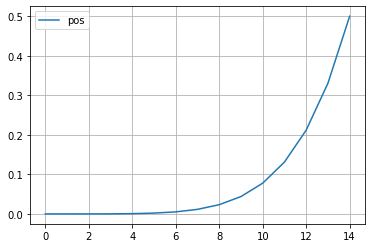

In [35]:
max_len = 15
a = []
b = []

for i in range(1, max_len+1):
  v = ((i/max_len)**6)/2
  a.append( v )
  b.append(1 + v )

plt.plot(a, label='pos')
#plt.plot(b, label='neg')
plt.legend()
plt.grid()


In [40]:
np.arange(12)[-3:]

array([ 9, 10, 11])

### Running the "Game"

In [0]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.activations import relu, softmax

from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import warnings 
with warnings.catch_warnings():  
  warnings.filterwarnings("ignore", category=FutureWarning)

tf.autograph.set_verbosity(0, False)

def run(df, fname, model=None, exp_replay=None):
    stats = []

    # parameters
    epsilon_0 = .1
    num_actions = 3 
    epoch = 300 #11500
    max_memory = 100 #10000
    max_game_len = 24 # 1000
    batch_size = tf.constant(20) #500
    lkbk = 50
    START_IDX = 3000
    
    env = Game(df, lkbk=lkbk, max_game_len=max_game_len, init_idx=START_IDX, run_mode='sequential')
    print('Model input shape:', len(env.state))
    
    hidden_size = tf.constant(len(env.state)*2)
    if(model is None):
      model = Sequential()
      model.add(Dense(hidden_size, input_shape=(tf.constant(len(env.state)),), activation=relu ))
      #model.add(Dropout(0.2))
      model.add(Dense(hidden_size, activation=relu))
      #model.add(Dropout(0.2))
      model.add(Dense(tf.constant(num_actions), activation=softmax))
      model.compile(Adam(lr=tf.constant(.005)), MSE)
      #model.compile(SGD(lr=tf.constant(.005)), MSE) # 1.51
      print('run()', model.summary())
    # If you want to continue training from a previous model, just uncomment the line bellow
    if(model is None and os.path.exists("indicator_model.h5")):
      model.load_weights("indicator_model.h5")

    # Initialize experience replay object
    if(exp_replay is None):
      exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    loss_cnt = 0
    wins = []
    losses = []
    pnls = []
    for e in range(epoch):
        epsilon = epsilon_0**(np.log10(e))
        env = Game(df, lkbk=lkbk, max_game_len=max_game_len,init_idx=env.curr_idx,run_mode='random')
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()
        #print(input_t)
        random_pos = False
        cnt = 0
        while not game_over:
            cnt += 1
            input_tm1 = input_t
            _input_tm1 = tf.convert_to_tensor(input_tm1)
            # get next action

            if np.random.rand() <= epsilon:
                random_pos = True
                action = np.random.randint(0, num_actions, size=1)[0]
                #print('run() - Random Action', action)
                if env.position == 0:
                    if action == 2:
                        exit_action = 1
                    elif action == 1:
                        exit_action = 2
                #if env.position and action == exit_action:
                #    print('***random exit***',env.position)
                #elif not env.position and action:
                #    print('***random entry***',env.position)
                    
            elif env.position == 0:
                
                #_input_tm1 = tf.convert_to_tensor(input_tm1)
                q = model.predict(_input_tm1)
                action = np.argmax(q[0])
                #print('run() - Predicted Action', action)
                if action:
                    #print(cnt)
                    exit_action = np.argmin(q[0][1:])+1
                
            elif cnt >= max_game_len or env.curr_time.hour*100+env.curr_time.minute >= 1745 :
                #print('***Time Exit***')
                action = exit_action
                
            elif env.position:
                #_input_tm1 = tf.convert_to_tensor(input_tm1)
                q = model.predict(_input_tm1)
                action = np.argmax(q[0])
                #print('run() - Predicted Action', action)

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if(game_over and reward > 0):
                win_cnt += 1
            elif reward < 0:
                loss_cnt += 1

            # store experience
            if action or len(exp_replay.memory)<20 or np.random.rand() < 0.1:
                exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
            #print('Shapes', cnt, inputs.shape, targets.shape)
            env.pnl_sum = sum(pnls)
            _inputs = tf.convert_to_tensor(inputs)
            _targets = tf.convert_to_tensor(targets)
            zz = model.train_on_batch(_inputs, _targets)
            
            loss += zz
        prt_str = ("Epoch {:03d} | Loss {:.2f} | zz {:.2f} | pos {} | len {} | pnl {:.2f}% @ {:.2f}% | eps {:,.4f} | win {:04d} | loss {:04d} {}".format(e, 
                                                                                      loss,
                                                                                      zz, 
                                                                                      env.position, 
                                                                                      env.trade_len,
                                                                                      sum(pnls)*100,
                                                                                      env.pnl*100,
                                                                                      epsilon,
                                                                                      win_cnt,
                                                                                      loss_cnt,
                                                                                      env.curr_time
                                                                                      ))
        stats.append({'loss':loss, 'pos':env.position, 'side': env.side, 'reward': env.reward ,'len':env.trade_len, 'cum_pnl':sum(pnls), 'cur_pnl':env.pnl, \
                      'win':1 if reward > 0 else -1, 'time':env.curr_time})
        print(prt_str)
        fid = open(fname,'a')
        fid.write(prt_str+'\n')
        fid.close()
        pnls.append(env.pnl)
        if not e%10:
            print('----saving weights-----')
            model.save_weights("indicator_model.h5", overwrite=True)

    return np.array(stats), model, exp_replay


In [47]:
fname = 'output1.dat'
fid = open(fname, 'w')
fid.close()
stats, model, exp = run(df, fname, None, None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10


Model input shape: 24
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_31 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 147       
Total params: 3,699
Trainable params: 3,699
Non-trainable params: 0
_________________________________________________________________
run() None
Epoch 000 | Loss 0.03 | zz 0.02 | pos 1 | len 4 | pnl 0.00% @ -0.44% | eps inf | win 0000 | loss 0001 2001-07-05 12:25:00
----saving weights-----
Epoch 001 | Loss 0.04 | zz 0.01 | pos -1 | len 3 | pnl -0.44% @ 0.08% | eps 1.0000 | win 0001 | loss 0001 2003-01-21 10:30:00
Epoch 002 | Loss 0.02 | zz 0.01 | pos -1 | len 1 | pnl -0.35% @ 0.18% | eps 

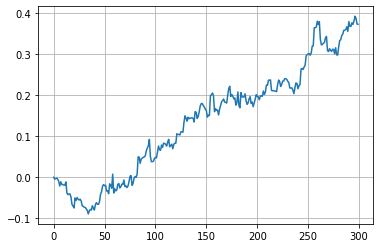

In [48]:
res = pd.DataFrame.from_records(stats)

res.cum_pnl.plot()
plt.grid()

#res.tail(20)

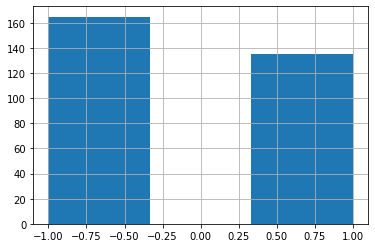

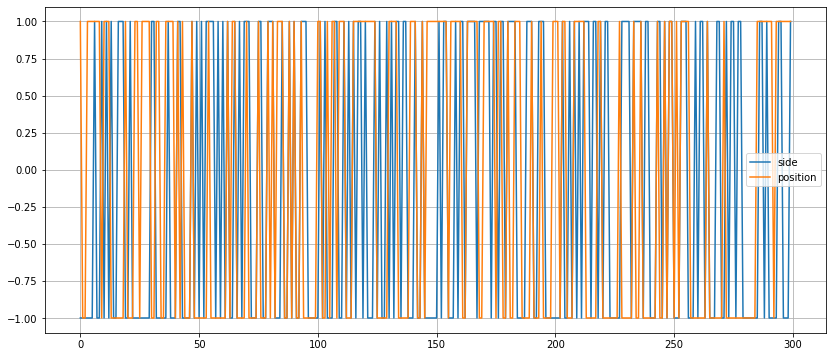

In [49]:
side = res.side
#side = side * res.pos

plt.hist(side, bins=3)
plt.grid()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(side, label='side')
plt.plot(res.pos, label='position')
plt.legend()
plt.grid()
plt.show()

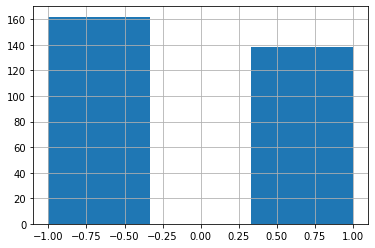

In [50]:
plt.hist(res.pos, bins=3)
plt.grid()

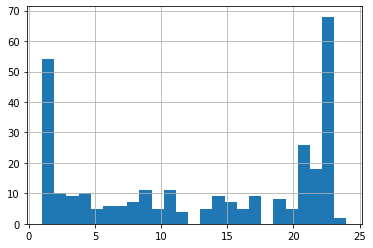

In [51]:
plt.hist(res.len, bins=25)
plt.grid()

In [52]:
res.pos.value_counts()

-1    162
 1    138
Name: pos, dtype: int64

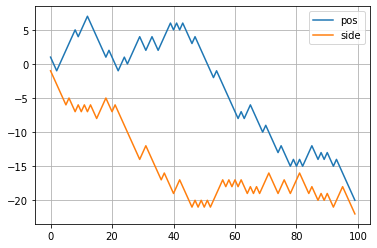

In [53]:
plt.plot(np.cumsum(res.pos[:100]), label='pos')
plt.plot(np.cumsum(res.side[:100]), label='side')
plt.legend()
plt.grid()
plt.show()

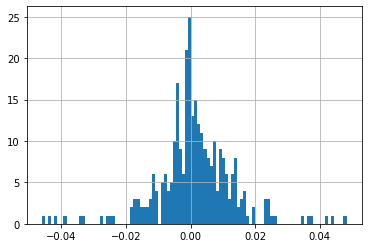

In [54]:
plt.hist(res.cur_pnl, bins=100) 
plt.grid()

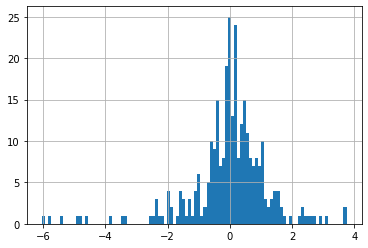

In [55]:
plt.hist(res.reward, bins=100) 
plt.grid()

In [0]:
df_test = df_full.iloc[80000:]
df_test.shape

In [0]:
epsilon_0 = .1
num_actions = 3 
#epoch = 200 #11500
max_memory = 1000 #10000
max_game_len = 15 # 1000
#batch_size = tf.constant(50) #500
lkbk = 25
START_IDX = 3000

env = Game(df_test, lkbk=lkbk, max_game_len=max_game_len, init_idx=START_IDX, run_mode='sequential')
env.reset()
game_over = False
# get initial input
input_t = env.observe()

cnt = 0
win_cnt = 0
loss_cnt = 0
pnl = 0
while not game_over:
    cnt += 1
    input_tm1 = input_t
    _input_tm1 = tf.convert_to_tensor(input_tm1)

    if env.position == 0:
        #_input_tm1 = tf.convert_to_tensor(input_tm1)
        q = model.predict(_input_tm1)
        action = np.argmax(q[0])
        #print('run() - Predicted Action', action)
        if action:
            #print(cnt)
            exit_action = np.argmin(q[0][1:])+1
        
    elif cnt >= max_game_len:
        #print('***Time Exit***')
        action = exit_action
        
    elif env.position:
        #_input_tm1 = tf.convert_to_tensor(input_tm1)
        q = model.predict(_input_tm1)
        action = np.argmax(q[0])
        #print('run() - Predicted Action', action)

    # apply action, get rewards and new state
    input_t, reward, game_over = env.act(action)
    if reward > 0:
        win_cnt += 1
    elif reward < 0:
        loss_cnt += 1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.download('indicator_model.h5')

In [0]:
!ls -l

In [0]:
!rm output1.dat
!rm indicator_model.h5